In [1]:
# We will need some functionality 
from typing import List 

import time

# and from math related libraries
import qutip as qt

import matplotlib.pyplot as plt

# and from qiskit
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator

import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z

from qiskit.utils.mitigation import CompleteMeasFitter


import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
#from qiskit.test.mock import FakeVigo
from qiskit.providers.fake_provider import FakeVigo

from qiskit.circuit import Parameter

In [7]:
def analog_ansatz(analog_block,num_qubits):
    psi = Parameter('a')
    theta = Parameter('b')

    qr = QuantumRegister(num_qubits)
    ansatz = QuantumCircuit(qr)

    # add some single-qubit gates
    for i in range(num_qubits-1):
        if i % 2 == 0:
            ansatz.rx(psi, i)
    ansatz.rz(theta, range(num_qubits))
    
    # analog block for multi-qubit mixing
    ansatz.unitary(analog_block, [qr[i] for i in range(num_qubits)], label='analog block')

    ansatz.barrier()
    
    return ansatz

def digital_ansatz(num_qubits):
    psi = Parameter('a')
    theta = Parameter('b')
 
    ansatz = QuantumCircuit(num_qubits)
    # add some single-qubit gates
    for i in range(num_qubits-1):
        if i % 2 == 0:
            ansatz.rx(psi, i)

    ansatz.rz(theta, range(num_qubits))

    # add a chain of CNOTs (multi-qubit gates)
    for i in range(num_qubits-1):
        ansatz.cx(i, i+1)
    ansatz.cx(num_qubits-1,0)
    
    ansatz.barrier()
    
    return ansatz

In [14]:

device_backend = FakeVigo()

backend = Aer.get_backend('aer_simulator')
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

algorithm_globals.random_seed = seed
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model, 
                     measurement_error_mitigation_cls=CompleteMeasFitter, 
                     cals_matrix_refresh_period=30)


def get_eigenvalue(which,num_qubits,ham_op,analog_block=0.0):
    counts = []
    values = []
    if which == "digital":
        chosen_ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')#digital_ansatz(num_qubits)
    else:
        chosen_ansatz = analog_ansatz(analog_block,num_qubits)
    
    print(chosen_ansatz)
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    spsa = SPSA(maxiter=iterations)
    vqe = VQE(chosen_ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
    result = vqe.compute_minimum_eigenvalue(operator=ham_op)
    final_eigval = result.eigenvalue.real
    print(which,": ",final_eigval)
    
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts, values, label=which)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.legend()
    pylab.title('Convergence with noise, measurement error mitigation enabled');
    

Number of qubits: 2
        ┌───────┐┌───────┐┌───────────────┐ ░ 
q389_0: ┤ Rx(a) ├┤ Rz(b) ├┤0              ├─░─
        ├───────┤└───────┘│  analog block │ ░ 
q389_1: ┤ Rz(b) ├─────────┤1              ├─░─
        └───────┘         └───────────────┘ ░ 
analog :  -1.9687500000000002

digital :  -1.974609375


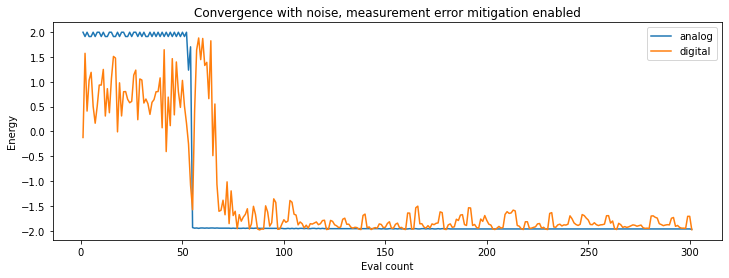

In [16]:
#H2_op = (-1.052373245772859 * I ^ I) + (0.39793742484318045 * I ^ Z) + (-0.39793742484318045 * Z ^ I) + (-0.01128010425623538 * Z ^ Z) + (0.18093119978423156 * X ^ X)
qubits_count = 2
coeff = 2.
H2_op = coeff * Z
for i in range(qubits_count-1):
    H2_op ^= Z

hamiltonian = H2_op.to_matrix()
ham_block = HamiltonianGate(data=hamiltonian, time=2) 

print(f'Number of qubits: {H2_op.num_qubits}')

get_eigenvalue("analog",qubits_count,H2_op,ham_block)
get_eigenvalue("digital",qubits_count,H2_op)